## TLDR
Tests pour sinkhorn et les buiders.
J'ai utilisé de 2 images arbitraires téléchargées dans un a dataset pour faire mes tests.
Pour les résultats, lire les sections conclusion des tests.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sinkhorn import sinkhorn
from builders import image2array, array2cost, image2array, transfer_color, array2image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Tests of Sinkhorn() with exact Gibbs kernel
### Initialization of managable variables:

In [28]:
# Points:
n=100**2 
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)
x=x[:,np.newaxis]
y=y[:,np.newaxis]
# Cost:
C = (x-y.T)**2
# entropy factor:
eta = 1 # il manque W <- W/eta dans l'algo alors garder eta=1
# (exact) Kernel:
Kmat = np.exp(-eta*C)
def K(v):
    return Kmat@v
def Kt(v):
    return (Kmat.T)@v
# Target marginals:
p = np.ones((n,1))
p = p / np.sum(p)
q = np.ones((n,1))
q = q / np.sum(q) 
# tolerance:
delta = 1e-15

### Sinkhorn projection computation:

W = -18.267731769488172
W = -18.267731769488144 (with other calculation)
Marginal error: 2.3889039618002483e-16


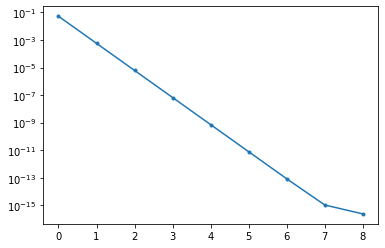

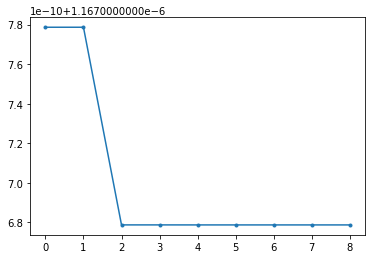

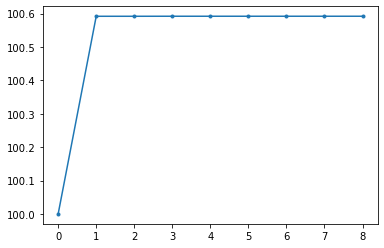

In [29]:
# Sinkhorn:
u,v,W,norm_u,norm_v,err = sinkhorn(K,Kt,p,q,delta,maxtime=10)
# Coupling:
P = u*Kmat*v.T
# Objective function:
Wbis = np.sum(C*P) - 1/eta * np.sum(P * np.log(1/P))
# Display:
print("W =",W)
print("W =",Wbis,"(with other calculation)")
print("Marginal error:",err[-1])
plt.semilogy(err,".-")
plt.figure()
plt.plot(norm_u,".-")
plt.figure()
plt.plot(norm_v,".-")

### Conclusions of test 1.
`Sinkhorn()` **Seem now to work well**. Marginal error **converge to zero with high precision and quite fast** for dimensions under $100^2$. The scallings vectors norms converge also to a certain value, showing the **stability of the convergence**. They do not necessarily have the same amplitude.

It remains to understand if the coding line that **increase the suport** is usefull.

Note que $W$ est **calculé faux dans le paper**, il manque un facteur $\eta^{-1}$, c'est embêtant parce $\eta$ est pas un paramètre de Sinkhorn mais caché dans le $K$. **Garder $\eta=1$** pour éviter le problème...

## 2. Tests de builders.py
J'ai download des images depuis un [dataset Kagel](https://www.kaggle.com/datasets/quantumsurt/ghibliimages?select=ghibli_jpg) et choisi deux arbitraires pour faire des tests: `chihiro_small_032.jpg` et `ged_small_025.jpg`
### Pixeliser les images en une taille raisonnable:

In [30]:
height = 100
width = 100

img1 = Image.open('chihiro_small_032.jpg') #open with the module PIL
img1.thumbnail((height, width),Image.ANTIALIAS) # resize
img1.convert('RGB').save('chihiro_small_032_small.jpg') #save in a file

img2 = Image.open('ged_small_025.jpg')
img2.thumbnail((height, width),Image.ANTIALIAS)
img2.convert('RGB').save('ged_small_025_small.jpg')

...en faire une fonction? On a juste besoin des fichiers alors peut être pas nécessaire.
### Initialisation des variables:

In [31]:
img1 = image2array('chihiro_small_032_small.jpg')
img2 = image2array('ged_small_025_small.jpg')
C,m1,m2 = array2cost(img1,img2)
C=C/10 # pour pas qu'il soit trop grand.
eta = 1 
Kmat = np.exp(-eta*C)
def K(v):
    return Kmat@v
def Kt(v):
    return (Kmat.T)@v
delta = 1e-10

### Sinkhorn projection computation:

W = -10.644464717248798
W = -10.644464717248843 (with other calculation)
Marginal error: 4.725213823735322e-11


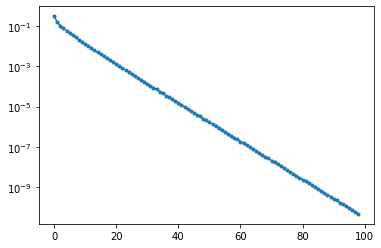

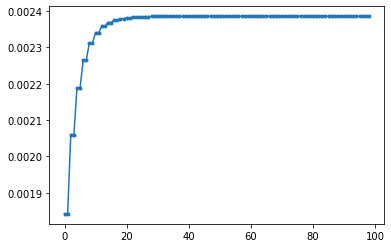

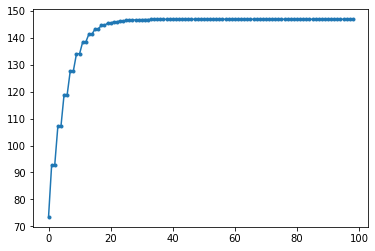

In [32]:
u,v,W,norm_u,norm_v,err = sinkhorn(K,Kt,m1,m2,delta,maxtime=10)
# Coupling:
P = u*Kmat*v.T
# Objective function:
Wbis = np.sum(C*P) - 1/eta * np.sum(P * np.log(1/P))
# Display evolution:
print("W =",W)
print("W =",Wbis,"(with other calculation)")
print("Marginal error:",err[-1])
plt.semilogy(err,".-")
plt.figure()
plt.plot(norm_u,".-")
plt.figure()
plt.plot(norm_v,".-")
# Compute resulting image
img3=transfer_color(P,img1)
# array2image('chihiro_small_032_small_newcolor.jpg', img3) #problem

### Conclusions du test 2. builders.py:
- les builders semblent bien marcher
- la pixelisation pose encore problème, elle ne donne pas réellement une image avec le nombre de pixels désiré: j'ai demandé $100\times 100=10'000$ et j'ai eu $5'400$.  J'ai remarqué le problème quand j'ai voulu refabriquer l'image finale à la toute dernière ligne. Une solution provisoire: retourner les dimensions de l'image dans le return de `image2array()`.
Autre solution: partir d'images du prof qui seraient déjà de bonne taille.
- L'amplitude du coût $C$: elle peut être plus ou moins grande si les images sont encodées en entiers et pas entre $0$ et $1$. Si c'est grand, on risque l'overflow parce qu'on prend son exponentielle pour calculer $K$. la reparamétriser est équivalent (mathématicalement) à changer $\eta$, et donc à changer le poids de l'entropie... à surveiller.